In [1]:
from models.memae import MEMAE
import torch
import matplotlib.pyplot as plt
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import glob
import numpy as np
from PIL import Image
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (4096, rlimit[1]))

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp
import random 


def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = False):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average and False: 
        return ssim_map.mean()
    else:
        return ssim_map
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)
         

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)


class HLoss(nn.Module):
    def __init__(self):
        super(HLoss, self).__init__()

    def forward(self, x):
        b = F.softmax(x, dim=1) * F.log_softmax(x, dim=1)
#         print (x.shape,b.shape)
        b = -1.0 * b
        return b.sum()

In [3]:
s_loss = SSIM().cuda()

In [61]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self,root_dir,start,end,train=True):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform=transforms.Compose([    transforms.Resize((98,98)),
#                                                transforms.RandomHorizontalFlip(p=0.5),
                                               transforms.Grayscale(num_output_channels=1),
                                               transforms.ToTensor()
                                           ])
        self.t_transform=transforms.Compose([    transforms.Resize((98,98)), 
                                               transforms.Grayscale(num_output_channels=1),
                                               transforms.ToTensor()
                                           ])
        self.train = train
        self.dataset = glob.glob(root_dir)[start:end] 
       

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
         

        img_name = self.dataset[idx]
        im = np.array(Image.open(img_name)) 
#         im = np.stack((im,)*3, axis=-1)
        im = Image.fromarray(im)
        if self.train:
            im = self.transform(im)
        else:
            im = self.t_transform(im)
        
         
        return im,im
dataset=FaceLandmarksDataset('../defect/datasets/infineon/train_memae/train/*',0,19000)
test_good = FaceLandmarksDataset('../defect/datasets/infineon/train_memae/train/*',0,1462,False)
test_bad = FaceLandmarksDataset('../defect/datasets/infineon/test/baad/*',00,8962,False)
print (dataset.__len__(),test_bad.__len__(),test_good.__len__())
dl = torch.utils.data.DataLoader(dataset,batch_size=64, shuffle=True,
                                             num_workers=4)
dl_test_bad = torch.utils.data.DataLoader(test_bad,batch_size=1, shuffle=False,
                                             num_workers=4)
dl_test_good = torch.utils.data.DataLoader(test_good,batch_size=1, shuffle=False,
                                             num_workers=4)


8711 462 1462


In [62]:
# pretrained = MEMAE(300).cuda()
 
# pretrained.load_state_dict(torch.load("./weight1.pt"))
model = MEMAE(1000).cuda()
model.load_state_dict(torch.load("./memae_ckpt/ssim_95_23.pt"))
# model.encoder.load_state_dict(pretrained.encoder.state_dict())
# model.decoder.load_state_dict(pretrained.decoder.state_dict()) 
model.train()

refiner = MEMAE(1000).cuda() 
refiner.train()

# for params in model.parameters():
#     params.requires_grad = False
 
# for params in zip(model.parameters(),refiner.parameters()):
#     print(params[0].requires_grad,params[1].requires_grad)

MEMAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (cosine_similarity): CosineSimilarity()
  (decoder): Decoder(
    (deconv0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (deconv1): ConvTranspose2d(64, 32, kerne

In [63]:
import cv2
def train(model,refiner,dataloader,criteria,optimizer,train=True,step=100):
    losses = list()
    if not train:
        model.eval()
    else:
        model.train()
    for i,(im,lab) in enumerate(dataloader):
        optimizer.zero_grad() 
        outputs = model(im.cuda())
        loss =  1-criteria(outputs, lab.cuda()) 
        
        refiner_output = 1 - criteria(outputs,model(outputs))  
          
        
        loss1 = cv2.GaussianBlur(loss.clone().cpu().detach().numpy()[0].reshape(98,98),(9,9),0)-  refiner_output.cpu().detach().numpy()[0].reshape(98,98)
 
        loss2 = np.sort(loss1.reshape(-1))
        loss2  = loss2
        losses.append((np.median(loss2)*np.median(loss2[-45:]),loss.cpu().detach().numpy().reshape(-1))) 
        
        phase = "Train" if train else "Test" 
        if i % step == 0 and   train:
            print (phase," Iteration: ",i,"LOSS : ",np.mean(loss1),"min:",np.min(loss1),"max:",np.max(loss1)\
               ,"med:",np.median(loss1),"zero:",loss1[loss1==0].shape) 
            inn = im.cpu().detach().numpy()[0]
            inn = np.transpose(inn,(1,2,0)) 
            outputs = outputs.cpu().detach().numpy()[0]  
            outputs[outputs>1]=1
            outputs = np.transpose(outputs,(1,2,0))[:,:,0] 
            
            
            plt.imshow(inn.reshape(98,98),cmap="gray")#.cpu().detach().numpy().reshape(98,98),cmap="gray")
            plt.show()
            plt.imshow(outputs,cmap="gray")
            plt.show()
            plt.imshow(loss1,cmap="gray")
            plt.show()
        if train:
            loss.mean().backward()
            optimizer.step()
     
    return losses

def calculate_acc(loss_lists):
    
    neg_np =  (np.array(loss_lists[0]))
    pos_np =  (np.array(loss_lists[1]))
    pos_np *=1000
    neg_np *=1000
    start,end = np.median(pos_np),np.median(neg_np) 
    
    thresholds = np.linspace(start, end, num=1000)
    accuracy = 0
    thres = 0
    print (pos_np.shape,neg_np.shape)
    
    for threh in thresholds: 
        if accuracy < ((pos_np[pos_np<threh].shape[0])+(neg_np[neg_np>=threh].shape[0])) / (pos_np.shape[0]+neg_np.shape[0]):

            accuracy = ((pos_np[pos_np<threh].shape[0])+(neg_np[neg_np>=threh].shape[0])) / (pos_np.shape[0]+neg_np.shape[0])
            thres  = threh
    print (accuracy,thres)
    print ("Positive",pos_np[pos_np<thres].shape,"Anomaly",neg_np[neg_np>=thres].shape, "Distribution")
    return accuracy,thres

In [64]:
import torch.optim as optim
import numpy
import sys
numpy.set_printoptions(threshold=sys.maxsize)
criteria = nn.MSELoss(reduction='none' ).cuda()
s_loss = SSIM().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
phases = {"test":[dl_test_bad,dl_test_good],"train":dl}
epoch = 0
max_acc = 0

while True:
    epoch+=1
    print ("Epoch ___________________________________",epoch)
    if epoch ==10000:
        break
    for phase in phases:
        loaders = phases[phase]
        if phase == 'train': 
            continue
            train(model,refiner,loaders,s_loss,optimizer,True,50)
        else:
            loss_lists = list()
            for loader in loaders:
                losses = train(model,refiner,loader,s_loss,optimizer,False,1)
                loss_lists.append(losses)
#             acc,thr = calculate_acc(loss_lists)
#             print ("ACCURACY: ",acc, "THRESHOLD: ",thr)
#             if max_acc < acc or True:
#                 torch.save(model.state_dict(),"./memae_ckpt/"+str(acc)+"_"+str(thr)+".pt")
#                 max_acc = acc
    break
#     
# /


Epoch ___________________________________ 1


In [65]:
print (len(loss_lists))

2


In [96]:
x_train = [sample[1] for i,sample in enumerate(loss_lists[0])] #+ [sample[1] for i,sample in enumerate(loss_lists[1])]
y_train = [1 for sample in loss_lists[0]] + [0 for sample in loss_lists[0]]
x_train = np.array(x_train) 
print(x_train.shape)
# y_train = np.array(y_train)
# from sklearn.svm import SVC
# from sklearn.svm import LinearSVC
# clf = LinearSVC(random_state=0, tol=1e-5)
# clf.fit(x_train, y_train)

# print(clf.score(x_train,y_train))


(462, 9604)


In [97]:
# from sklearn.ensemble import IsolationForest
# clf = IsolationForest(random_state=0,contamination=0.05)
# clf.fit(x_train)
result = clf.predict(x_train)
result[result==-1].shape

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


(251,)

In [29]:
distances = []
counter = 0
for i in range(462):
    distance = np.linalg.norm(kmeans.cluster_centers_ - x_train[i])
    if distance > 2:
        counter+=1
    distances.append(distance)
print(max(distances),np.mean(distances),np.median(distances),np.min(distances),counter)

35.952335 5.5638337 3.8766234 1.2525527 368


In [30]:
print (y_true.shape,len(pos),len(neg))
print(pred.shape)
print (pred[:10])
print (pred[-10:])

NameError: name 'y_true' is not defined

In [ ]:
print(roc_auc_score( y_true,pred))
average_precision_score(y_true,pred)

In [ ]:
mem = 100, vector = 64 samples = 3000
    2 and 0 = 97.9.42%
    2 and 1 = 56.8%
    2 and 2 = 99.2%
    2 and 3 = 96.9%
    2 and 4 = 98.3%
    2 and 5 = 98.9.6%
    2 and 6 = 98.42%
    2 and 7 = 90.14%
    2 and 8 = 98.42%
    2 and 9 = 97.07%


     
    20 and 1 = 95.28%
    2 and 2 = 99.0%
    2 and 3 = 93.0%
    2 and 4 = 98.3%
    2 and 5 = 97.2.6%
    2 and 6 = 98.42%
    2 and 7 = 97.14%
    2 and 8 = 98.82%
    2 and 9 = 97.07%
    
    21 and 0 = 1%
    2 and 2 = 1%
    2 and 3 = 1%
    2 and 4 = 1%
    2 and 5 = 1%
    2 and 6 = 1%
    2 and 7 = 1%
    2 and 8 = 1%
    2 and 9 = 1%
    
     23 and 0 = 0.99%
    2 and 1 = 0.51%
    2 and 2 = 93%
    2 and 4 = 98%
    2 and 5 = 97%
    2 and 6 = 91%
    2 and 7 = 88%
    2 and 8 = 95%
    2 and 9 = 93%

In [ ]:
1 make supervised
2) accu wholes
3 train on complete images

In [39]:
from sklearn.manifold import TSNE
RS = 7657
tsne = TSNE(n_components=2, verbose=1 , perplexity =20,random_state = RS) 
fashion_tsne = tsne.fit_transform(x_train)
print (fashion_tsne.shape)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 924 samples in 0.173s...
[t-SNE] Computed neighbors for 924 samples in 13.176s...
[t-SNE] Computed conditional probabilities for sample 924 / 924
[t-SNE] Mean sigma: 0.262202
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.796181
[t-SNE] KL divergence after 1000 iterations: 1.191243
(924, 2)


In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    plt.title("Green=Good,   Red=Bad(Inline),   Purple=Train Good embedings \n\n Trained only on Synthetic Burr and Height"  )
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(924, 9604) (924,)


(<Figure size 576x576 with 1 Axes>,
 [Text(-1.2836,2.20124,'0'), Text(1.00906,0.0443198,'1')])

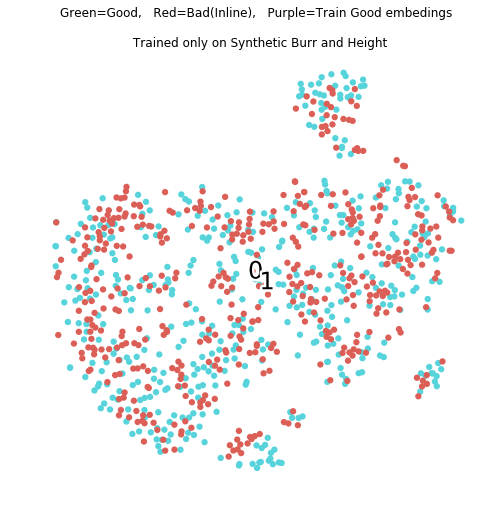

In [41]:
print (x_train.shape,y_train.shape)
fashion_scatter(fashion_tsne,y_train)

In [42]:
import numpy as np
avg_temp = np.array([24.0, 28.9, 28.9, 29.0, 29.1, 29.1, 29.2, 29.2, 29.3, 29.4])

mean = avg_temp.mean()
std = avg_temp.std()
sigma = std^2
print (mean, std, sigma) //28.61 1.54431214461 2.3849

SyntaxError: invalid syntax (<ipython-input-42-8769fbd3a380>, line 7)